# check gene verteilung

In [1]:
import scanpy as sc
pyEDsoup = sc.read_h5ad("04_soup/pyED_correct_soupx.h5ad")
print(pyEDsoup)

pyED = sc.read_h5ad("../data/pyED_correct.h5ad")
pyED

AnnData object with n_obs × n_vars = 8202 × 22037
    uns: 'X_name'


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


AnnData object with n_obs × n_vars = 8202 × 22040
    obs: 'Total', 'PValue', 'Limited', 'LogProb', 'FDR'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'empty_drops'

In [58]:
import math

millnames = ['',' Thousand',' Million',' Billion',' Trillion']

def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])


# calculate total counts of both objects and subtract them
total_counts_pyED = pyED.X.sum()
print("total UMI counts pyED: ", total_counts_pyED)
total_counts_pyEDsoup = pyEDsoup.X.sum()
print("total UMI counts pyEDsoup: ", total_counts_pyEDsoup)
total_reduction = total_counts_pyED - total_counts_pyEDsoup
print("total UMI counts reduction: ", total_reduction)

print("total reduction of ", millify(total_reduction), " UMI counts through soupX")

total UMI counts pyED:  28113800.0
total UMI counts pyEDsoup:  21675729.005999804
total UMI counts reduction:  6438070.994000196
total reduction of  6 Million  UMI counts through soupX


6438070


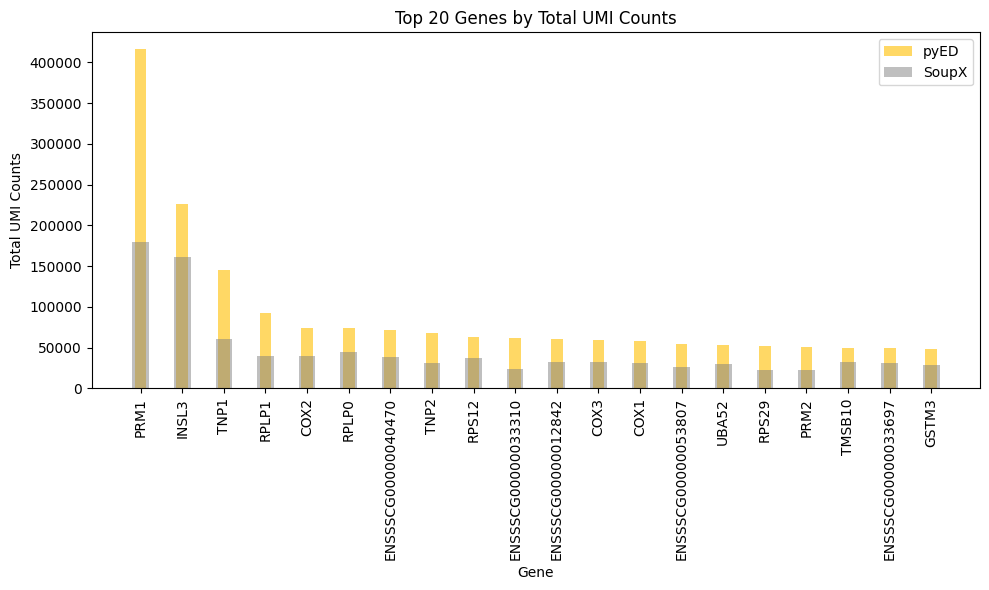

In [18]:
# total counts
abgezogen = pyED.X.sum() - pyEDsoup.X.sum()
print(int(abgezogen))

# plot the distribution of the counts in descending order of total umi per barcode
import matplotlib.pyplot as plt
import numpy as np

def plot_top20_genes(AnnData, BnnData):
    # Get total UMI counts for each gene (sum over cells) in AnnData
    total_umi_per_gene_A = AnnData.X.sum(axis=0)
    # Ensure 1D numpy array
    if hasattr(total_umi_per_gene_A, "A1"):
        total_umi_per_gene_A = total_umi_per_gene_A.A1
    elif hasattr(total_umi_per_gene_A, "toarray"):
        total_umi_per_gene_A = np.asarray(total_umi_per_gene_A).flatten()
    else:
        total_umi_per_gene_A = np.asarray(total_umi_per_gene_A).flatten()

    # Find top 20 genes for AnnData
    sorted_indices_A = np.argsort(total_umi_per_gene_A)[::-1]
    top20_indices_A = sorted_indices_A[:20]
    top20_counts_A = total_umi_per_gene_A[top20_indices_A]
    top20_gene_names = AnnData.var_names[top20_indices_A]

    # Get total UMI counts for each gene in BnnData
    total_umi_per_gene_B = BnnData.X.sum(axis=0)
    if hasattr(total_umi_per_gene_B, "A1"):
        total_umi_per_gene_B = total_umi_per_gene_B.A1
    elif hasattr(total_umi_per_gene_B, "toarray"):
        total_umi_per_gene_B = np.asarray(total_umi_per_gene_B).flatten()
    else:
        total_umi_per_gene_B = np.asarray(total_umi_per_gene_B).flatten()

    # Map BnnData counts to the same genes (by name and order) as AnnData top20
    # This handles the possible case where the two AnnData objects have different var_names orderings
    top20_gene_names_list = list(top20_gene_names)
    indices_B_in_Aorder = [BnnData.var_names.get_loc(gene) if gene in BnnData.var_names else None for gene in top20_gene_names_list]
    # Handle missing genes
    top20_counts_B = []
    for idx in indices_B_in_Aorder:
        if idx is not None:
            top20_counts_B.append(total_umi_per_gene_B[idx])
        else:
            top20_counts_B.append(0)
    top20_counts_B = np.array(top20_counts_B)

    # Plot the bars for both AnnData (BnnData first, then AnnData in front)
    plt.figure(figsize=(10, 6))
    width = 0.4
    x = np.arange(20)
    plt.bar(x, top20_counts_A, width=width*0.7, color='#FFCF3E', label='pyED', alpha=0.8)
    plt.bar(x, top20_counts_B, width=width, color='gray', label='SoupX', alpha=0.5)
    plt.xticks(x, top20_gene_names, rotation=90)
    plt.xlabel('Gene')
    plt.ylabel('Total UMI Counts')
    plt.title('Top 20 Genes by Total UMI Counts')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_top20_genes(pyED, pyEDsoup)

Total reduction in UMI counts per cell type (using exclusive marker genes, grouped by alias):
Early Spermatogonia : 999
Late Spermatogonia  : 2389
Early Spermatocytes : 167
Late Spermatocytes  : 113
Round Spermatids    : 12361
Elongated Spermatids: 321451
Sertoli Cells       : 650
Leydig Cells        : 11868
Total reduction in UMI counts per cell type (by mapped assignment, grouped by alias):
Early Spermatogonia : 39451
Late Spermatogonia  : 0
Early Spermatocytes : 1184227
Late Spermatocytes  : 360807
Round Spermatids    : 1957072
Elongated Spermatids: 615946
Sertoli Cells       : 1197505
Leydig Cells        : 1083063


/var/folders/06/zfzddxwn4hd0ywccb30sl4qw0000gn/T/ipykernel_33752/2108771262.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(celltype_axis_order, rotation=45, ha='right')
/var/folders/06/zfzddxwn4hd0ywccb30sl4qw0000gn/T/ipykernel_33752/2108771262.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(celltype_axis_order, rotation=45, ha='right')


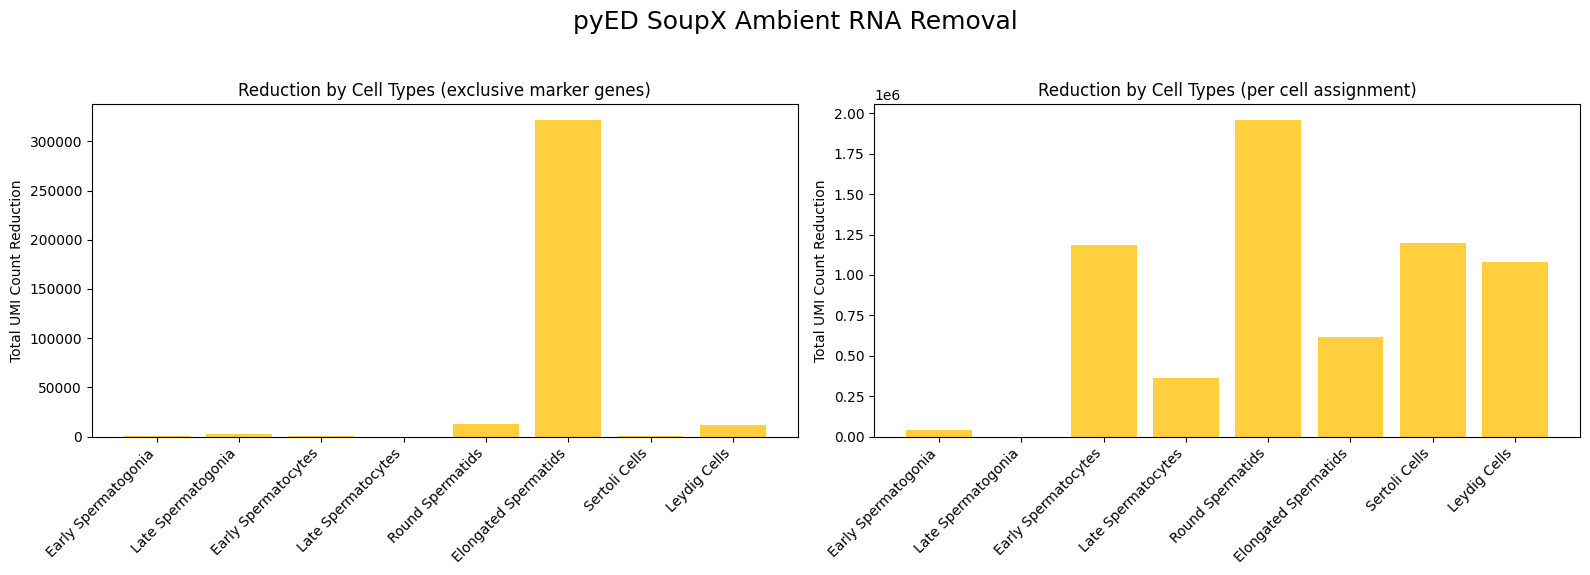

In [34]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Exclusive marker based plot (as before) ---

# Load exclusive gene markers for each cell type
with open("02_mapped_gene_markers/exclusive_gene_markers.json", "r") as f:
    exclusive_markers = json.load(f)

# Helper to map slightly different names between colorcodes and exclusive_marker types
celltype_alias_map = {
    "Early Sgonia": "Early Spermatogonia",
    "Late Sgonia": "Late Spermatogonia",
    "Early Scytes": "Early Spermatocytes",
    "Late Scytes": "Late Spermatocytes",
    "Round Stids": "Round Spermatids",
    "Later Stids": "Elongated Spermatids",
    "Sertoli": "Sertoli Cells",
    "Leydig": "Leydig Cells",
}

# Define the desired cell type plotting order (still tied to exclusive_markers keys and cluster assignments)
celltype_order = [
    "Early Sgonia",
    "Late Sgonia",
    "Early Scytes",
    "Late Scytes",
    "Round Stids",
    "Later Stids",
    "Sertoli",
    "Leydig"
]

# Get unique cell type names for plotting axes (from the .values() of the alias map, preserving order of first appearance)
from collections import OrderedDict

celltype_axis_order = []
for ctype in celltype_order:
    alias = celltype_alias_map[ctype]
    if alias not in celltype_axis_order:
        celltype_axis_order.append(alias)

# Prepare summary for each (major) cell type, keyed by alias name
gene_reduction_per_alias = {alias: 0.0 for alias in celltype_axis_order}

for celltype_key in celltype_order:
    colorcode_key = celltype_alias_map[celltype_key]
    genes = exclusive_markers[celltype_key]
    reduction_info = []
    for gene in genes:
        # Check if gene exists in both AnnData objects (pyED and pyEDsoup)
        if gene in pyED.var_names and gene in pyEDsoup.var_names:
            count_pyED = pyED.X[:, pyED.var_names.get_loc(gene)].sum()
            count_pyEDsoup = pyEDsoup.X[:, pyEDsoup.var_names.get_loc(gene)].sum()
            reduction = (count_pyED - count_pyEDsoup)
        else:
            count_pyED = pyED.X[:, pyED.var_names.get_loc(gene)].sum() if gene in pyED.var_names else 0
            count_pyEDsoup = pyEDsoup.X[:, pyEDsoup.var_names.get_loc(gene)].sum() if gene in pyEDsoup.var_names else 0
            reduction = (count_pyED - count_pyEDsoup)
        reduction_info.append(reduction)
    total_reduction = float(np.sum(reduction_info))
    gene_reduction_per_alias[colorcode_key] += total_reduction  # sum for shared aliases (e.g. Early/Late Sgonia)

print("Total reduction in UMI counts per cell type (using exclusive marker genes, grouped by alias):")
for alias in celltype_axis_order:
    reduction = gene_reduction_per_alias[alias]
    print(f"{alias:20s}: {reduction:.0f}")

# --- 2. Per-cell mapped cell types from CSV ---

# Load cluster cell type mapping from CSV (column: cluster_type)
# File: "03_mapped_clusters/pyED_cluster_celltype.csv"
cluster_map = pd.read_csv("03_mapped_clusters/pyED_cluster_celltype.csv")
if "cluster_type" not in cluster_map.columns:
    raise ValueError("Column 'cluster_type' not found in pyED_cluster_celltype.csv!")

cluster_types = cluster_map["cluster_type"].values  # Length must match n_obs in pyED

if len(cluster_types) != pyED.shape[0]:
    raise ValueError(f"pyED_cluster_celltype.csv contains {len(cluster_types)} rows but AnnData has {pyED.shape[0]} cells!")

# Compute total UMI (sum of all genes) for each cell, for both AnnData objects
def total_umi_per_cell_matrix(X):
    # Compatibility with sparse and dense
    if hasattr(X, "sum"):
        return np.array(X.sum(axis=1)).flatten()
    else:
        return np.sum(X, axis=1)

pyED_umis = total_umi_per_cell_matrix(pyED.X)
pyEDsoup_umis = total_umi_per_cell_matrix(pyEDsoup.X)

# Sum up total UMI per cell type (by mapped cells), grouped into colorcode/alias names
type2reduction_alias = {alias: 0.0 for alias in celltype_axis_order}
# The assignment needs to add values corresponding to their mapped alias
for ctype in celltype_order:
    alias = celltype_alias_map[ctype]
    ctype_cells = np.where(cluster_types == ctype)[0]
    if len(ctype_cells) == 0:
        continue
    t_pyED = pyED_umis[ctype_cells].sum()
    t_pyEDsoup = pyEDsoup_umis[ctype_cells].sum()
    type2reduction_alias[alias] += float(t_pyED - t_pyEDsoup)

print("Total reduction in UMI counts per cell type (by mapped assignment, grouped by alias):")
for alias in celltype_axis_order:
    reduction = type2reduction_alias[alias]
    print(f"{alias:20s}: {reduction:.0f}")

# --- Combined Figure with Two Subplots using alias cell types for axis ---

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
bar_color = "#FFCF3E"

# Left subplot: Exclusive marker (gene-based) reduction, grouped by colorcode/alias
axs[0].bar(celltype_axis_order, [gene_reduction_per_alias[alias] for alias in celltype_axis_order], color=bar_color)
axs[0].set_ylabel('Total UMI Count Reduction')
axs[0].set_title('Reduction by Cell Types (exclusive marker genes)')
axs[0].set_xticklabels(celltype_axis_order, rotation=45, ha='right')

# Right subplot: Per-cell mapped assignment, grouped by colorcode/alias
axs[1].bar(celltype_axis_order, [type2reduction_alias[alias] for alias in celltype_axis_order], color=bar_color)
axs[1].set_ylabel('Total UMI Count Reduction')
axs[1].set_title('Reduction by Cell Types (per cell assignment)')
axs[1].set_xticklabels(celltype_axis_order, rotation=45, ha='right')

fig.suptitle("pyED SoupX Ambient RNA Removal", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("05_figures/cell_type_reduction.png")
plt.show()

In [52]:
import pandas as pd
import numpy as np

def build_reduction_table(marker_genes):
    # Alias maps for readability, using colorcode-aligned names
    celltype_alias_names = [
        "Early Spermatogonia",
        "Late Spermatogonia",
        "Early Spermatocytes",
        "Late Spermatocytes",
        "Round Spermatids",
        "Elongated Spermatids",
        "Sertoli Cells",
        "Leydig Cells"
    ]
    celltype_alias_map_for_table = dict(zip(celltype_axis_order, celltype_alias_names))

    stat_names = ["pyED", "pyEDsoup", "%reduction"]
    rows = []
    row_labels = []

    for gene in marker_genes:
        for stat in stat_names:
            row_labels.append(f"{gene}-{stat}")
            row_data = []
            for alias in celltype_axis_order:
                try:
                    gene_idx = list(pyED.var_names).index(gene)
                except ValueError:
                    pyed_val, pyedsoup_val, percent_reduction = float('nan'), float('nan'), float('nan')
                else:
                    ctype_names = [ctype for ctype, a in celltype_alias_map.items() if a == alias]
                    ctype_cells = np.concatenate([np.where(cluster_types == c)[0] for c in ctype_names])
                    pyed_val = pyED.X[ctype_cells, gene_idx].sum() if len(ctype_cells) > 0 else 0.0
                    pyedsoup_val = pyEDsoup.X[ctype_cells, gene_idx].sum() if len(ctype_cells) > 0 else 0.0
                    if pyed_val > 0:
                        percent_reduction = 100. * (pyed_val - pyedsoup_val) / pyed_val
                    else:
                        percent_reduction = float('nan')
                if stat == "pyED":
                    row_data.append(pyed_val)
                elif stat == "pyEDsoup":
                    row_data.append(pyedsoup_val)
                elif stat == "%reduction":
                    row_data.append(percent_reduction)
            rows.append(row_data)

    # Build dataframe: columns are cell types, rows are <GENE>-<stat>
    df = pd.DataFrame(rows, index=row_labels, columns=[celltype_alias_map_for_table[alias] for alias in celltype_axis_order])

    # Round all values: pyED and pyEDsoup to 0 decimals, %reduction to 2 decimals
    for i, label in enumerate(row_labels):
        if label.endswith('-pyED') or label.endswith('-pyEDsoup'):
            df.iloc[i] = df.iloc[i].round(0)
        elif label.endswith('-%reduction'):
            df.iloc[i] = df.iloc[i].round(2)

    # Save and print as before
    print(df)
    #df.to_csv("05_figures/reduction_table_exclusive_markers.csv")
    return df

# Example of function call:
def flatten(xss):
    return [x for xs in xss for x in xs]
input_name = "exclusive_markers"  # the json file
print(len(flatten(exclusive_markers.values())))
df = build_reduction_table(flatten(exclusive_markers.values()))
df.to_csv(f"05_figures/reduction_table_{input_name}.csv")

input_name = "random_genes"
random_genes = ["PRM1", "TNP1", "SOX9", "ID4"]
df = build_reduction_table(random_genes)
df.to_csv(f"05_figures/reduction_table_{input_name}.csv")


72
                   Early Spermatogonia  Late Spermatogonia  \
GFRA1-pyED                         0.0                 0.0   
GFRA1-pyEDsoup                     0.0                 0.0   
GFRA1-%reduction                   NaN                 NaN   
ID4-pyED                           0.0                 0.0   
ID4-pyEDsoup                      28.0                 0.0   
...                                ...                 ...   
VCAM1-pyEDsoup                     0.0                 0.0   
VCAM1-%reduction                 100.0                 NaN   
HSD3B6-pyED                        NaN                 NaN   
HSD3B6-pyEDsoup                    NaN                 NaN   
HSD3B6-%reduction                  NaN                 NaN   

                   Early Spermatocytes  Late Spermatocytes  Round Spermatids  \
GFRA1-pyED                       19.00                 3.0             11.00   
GFRA1-pyEDsoup                    0.00                 0.0              0.00   
GFRA1-%reduc

In [ ]:
# print total reduction per cell tye